In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
import scipy.stats as stats
from scipy.stats import zscore
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pingouin as pg
import plotly.express as px 
import plotly.io as pio
# pio.renderers.default='browser'

In [2]:
# Importando o banco de dados

varejista = pd.read_excel('data/regional_varejista.xlsx')
## Fonte: Fávero & Belfiore (2024, Capítulo 9)

In [3]:
# Visualizando os dados

print(varejista.info())

# Estatísticas descritivas das variáveis

print(varejista[['atendimento','sortimento', 'organização']].describe())
## Neste caso, não faremos a padronização. As variáveis estão na mesma escala!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   loja         18 non-null     int64 
 1   regional     18 non-null     object
 2   atendimento  18 non-null     int64 
 3   sortimento   18 non-null     int64 
 4   organização  18 non-null     int64 
dtypes: int64(4), object(1)
memory usage: 852.0+ bytes
None
       atendimento  sortimento  organização
count    18.000000   18.000000    18.000000
mean     28.111111   27.888889    33.111111
std      27.003026   30.497616    37.247801
min       2.000000    2.000000     2.000000
25%       6.000000    4.000000     4.000000
50%      11.000000    6.000000     6.000000
75%      52.000000   51.500000    55.000000
max      78.000000   86.000000   100.000000


In [4]:
# Ajustando o banco de dados

# Retirando todos os dados que não são numéricos do dataset

varejo = varejista.drop(columns=['loja','regional'])

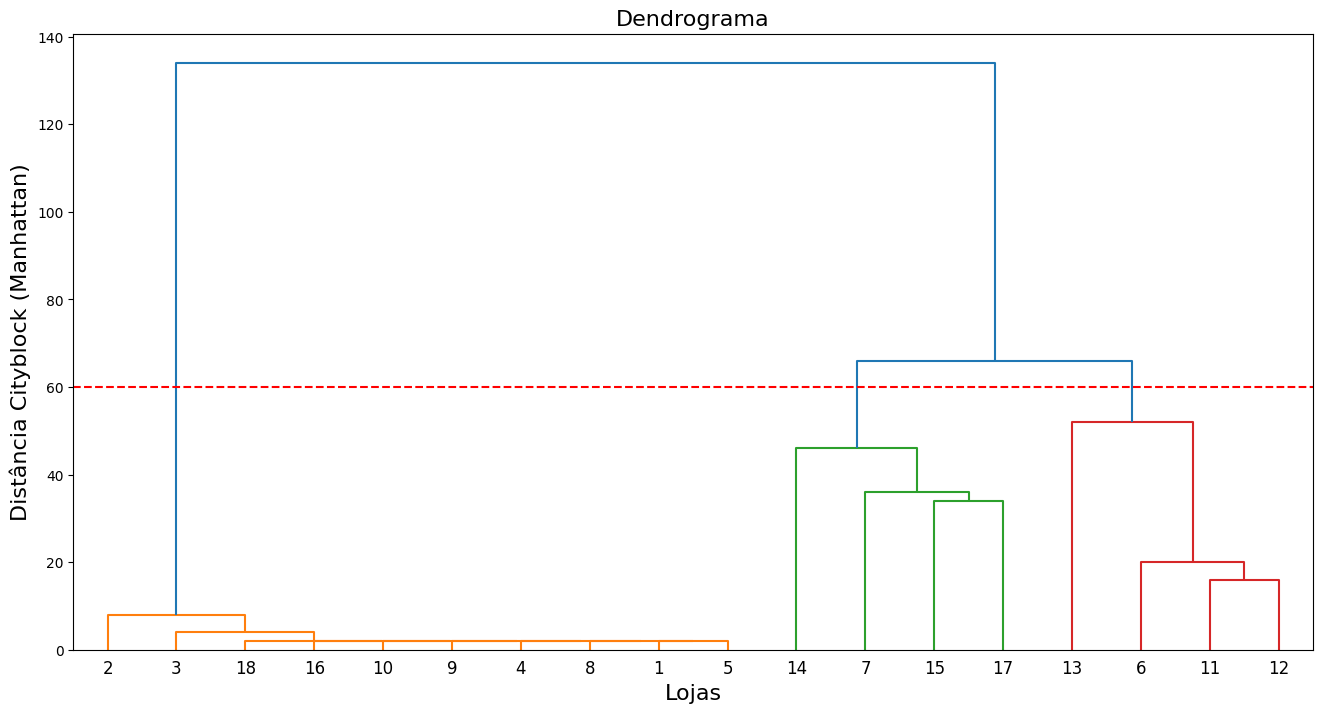

In [5]:
# Cluster Hierárquico Aglomerativo: single linkage + distância cityblock

# Gerando o dendrograma

plt.figure(figsize=(16,8))
dend_sing = sch.linkage(varejo, method = 'single', metric = 'cityblock')
dendrogram_s = sch.dendrogram(dend_sing, color_threshold = 60, labels = list(varejista.loja))
plt.title('Dendrograma', fontsize=16)
plt.xlabel('Lojas', fontsize=16)
plt.ylabel('Distância Cityblock (Manhattan)', fontsize=16)
plt.axhline(y = 60, color = 'red', linestyle = '--')
plt.show()

In [6]:
# Criando a variável que indica os clusters no banco de dados

cluster_sing = AgglomerativeClustering(n_clusters = 3, metric = 'cityblock', linkage = 'single')
indica_cluster_sing = cluster_sing.fit_predict(varejo)
varejista['cluster_single'] = indica_cluster_sing
varejista['cluster_single'] = varejista['cluster_single'].astype('category')

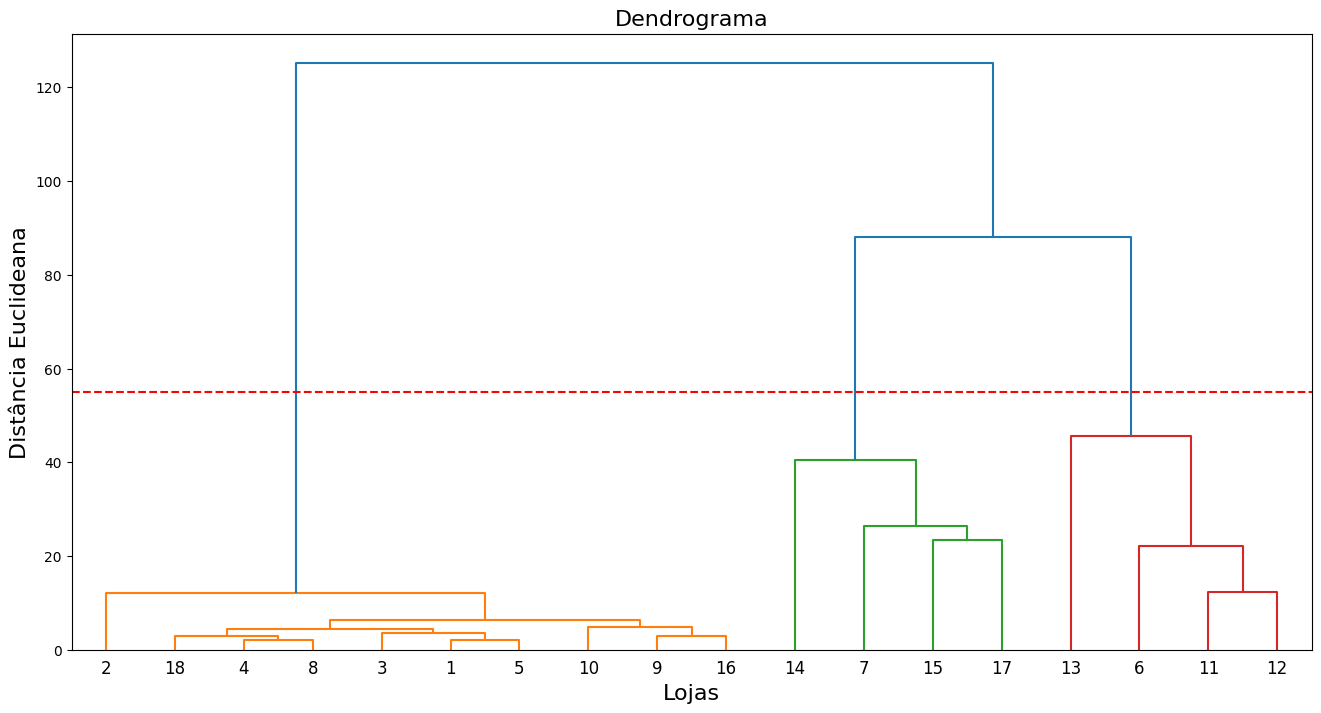

In [7]:
# Cluster Hierárquico Aglomerativo: complete linkage + distância euclidiana

# Gerando o dendrograma

plt.figure(figsize=(16,8))
dend_sing_euc = sch.linkage(varejo, method = 'complete', metric = 'euclidean')
dendrogram_euc = sch.dendrogram(dend_sing_euc, color_threshold = 55, labels = list(varejista.loja))
plt.title('Dendrograma', fontsize=16)
plt.xlabel('Lojas', fontsize=16)
plt.ylabel('Distância Euclideana', fontsize=16)
plt.axhline(y = 55, color = 'red', linestyle = '--')
plt.show()

In [8]:
# Criando a variável que indica os clusters no banco de dados

cluster_comp = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'complete')
indica_cluster_comp = cluster_comp.fit_predict(varejo)
varejista['cluster_complete'] = indica_cluster_comp
varejista['cluster_complete'] = varejista['cluster_complete'].astype('category')

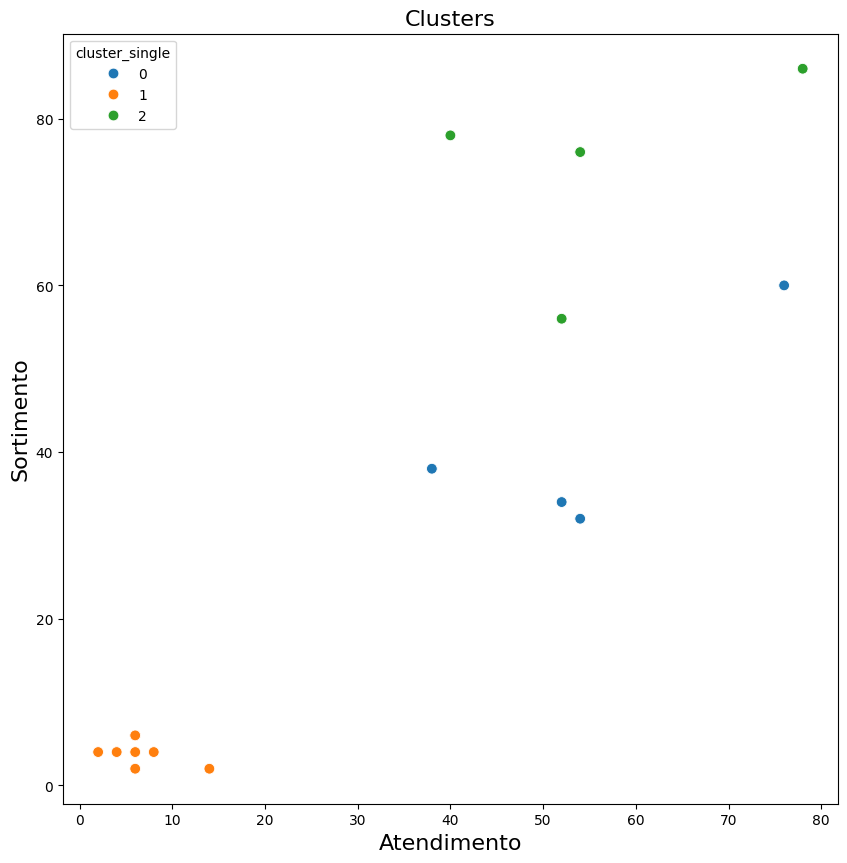

In [9]:
# Plotando as observações e seus clusters (single + cityblock)

plt.figure(figsize=(10,10))
fig = sns.scatterplot(x='atendimento', y='sortimento', s=60, data=varejista, hue='cluster_single')
plt.title('Clusters', fontsize=16)
plt.xlabel('Atendimento', fontsize=16)
plt.ylabel('Sortimento', fontsize=16)
plt.show()

In [10]:
# Método K-Means

# Considerando que identificamos 3 possíveis clusters na análise hierárquica

kmeans_varejista = KMeans(n_clusters=3, init='random', random_state=100).fit(varejo)

# Criando a variável que indica os clusters no banco de dados

kmeans_clusters = kmeans_varejista.labels_
varejista['cluster_kmeans'] = kmeans_clusters
varejista['cluster_kmeans'] = varejista['cluster_kmeans'].astype('category')
## O padrão dos clusters é o mesmo dos métodos hierárquicos anteriores

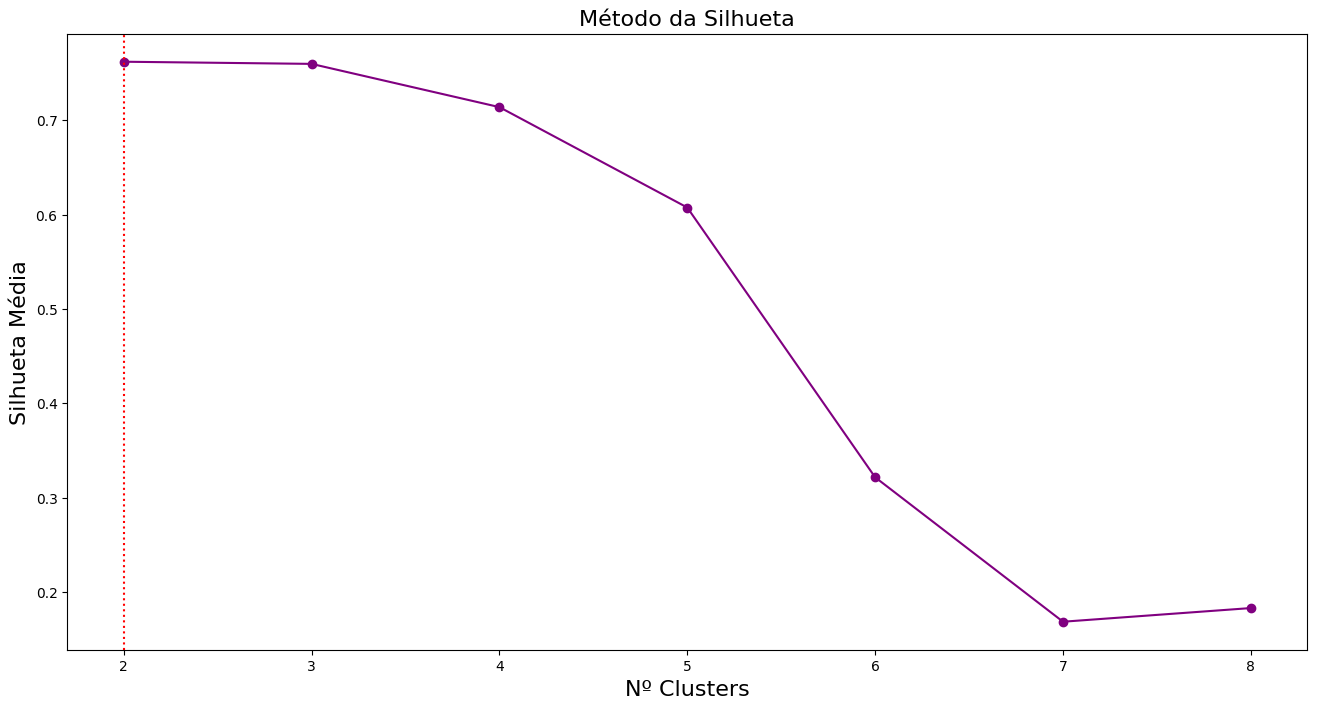

In [12]:
# Método da silhueta para identificação do nº de clusters

silhueta = []
I = range(2,9) # ponto de parada pode ser parametrizado manualmente
for i in I: 
    kmeansSil = KMeans(n_clusters=i, init='random', random_state=100).fit(varejo)
    silhueta.append(silhouette_score(varejo, kmeansSil.labels_))

plt.figure(figsize=(16,8))
plt.plot(range(2, 9), silhueta, color = 'purple', marker='o') # Ajustar range
plt.xlabel('Nº Clusters', fontsize=16)
plt.ylabel('Silhueta Média', fontsize=16)
plt.title('Método da Silhueta', fontsize=16)
plt.axvline(x = silhueta.index(max(silhueta))+2, linestyle = 'dotted', color = 'red') 
plt.show()

*A silhueta média é praticamente igual em 2 ou 3 clusters!*

*Para aprimorar a interpretação, vamos manter 3 clusters!*

In [13]:
# Coordenadas dos centroides dos clusters finais

cent_finais = pd.DataFrame(kmeans_varejista.cluster_centers_)
cent_finais.columns = varejo.columns
cent_finais.index.name = 'cluster'
cent_finais

,atendimento,sortimento,organização
cluster,,,
0,6.2,4.2,4.4
1,56.0,74.0,45.0
2,55.0,41.0,93.0


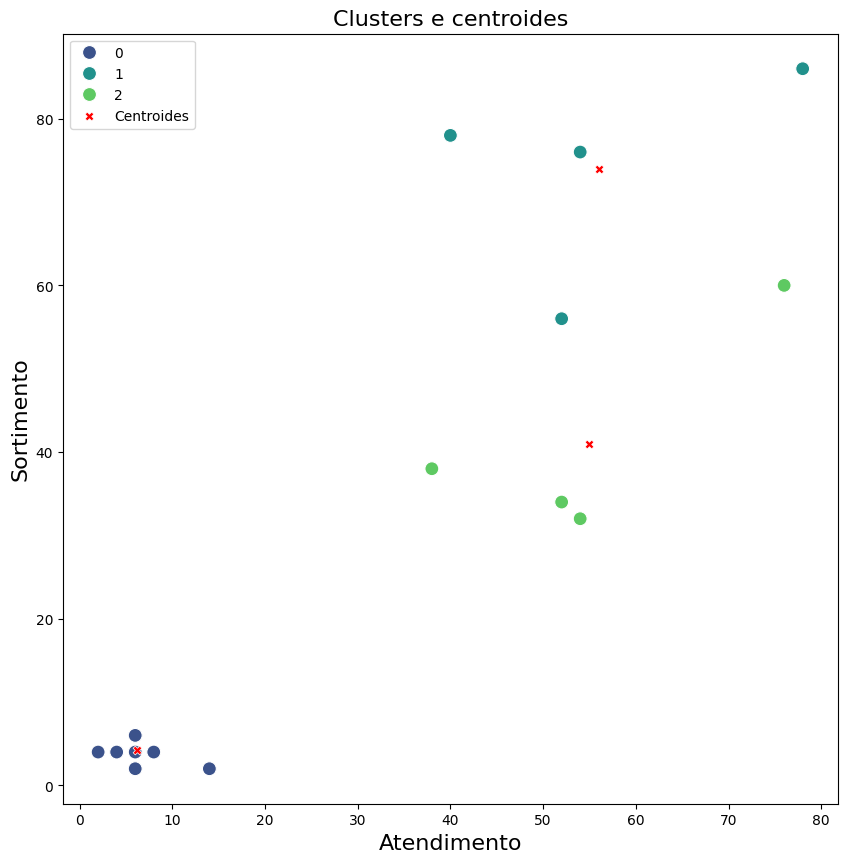

In [14]:
# Plotando as observações e seus centroides dos clusters

plt.figure(figsize=(10,10))
sns.scatterplot(x='atendimento', y='sortimento', data=varejista, hue='cluster_kmeans', palette='viridis', s=100)
sns.scatterplot(x='atendimento', y='sortimento', data=cent_finais, s=40, c='red', label='Centroides', marker="X")
plt.title('Clusters e centroides', fontsize=16)
plt.xlabel('Atendimento', fontsize=16)
plt.ylabel('Sortimento', fontsize=16)
plt.legend()
plt.show()

In [16]:
varejista.columns

Index(['loja', 'regional', 'atendimento', 'sortimento', 'organização',
       'cluster_single', 'cluster_complete', 'cluster_kmeans'],
      dtype='object')

In [17]:
for coluna in ['atendimento', 'sortimento', 'organização']:
    print(coluna)
    display(
        pg.anova(dv=coluna, 
                between='cluster_kmeans', 
                data=varejista,
                detailed=True).T
    )

atendimento


,0,1
Source,cluster_kmeans,Within
SS,10804.177778,1591.6
DF,2,15
MS,5402.088889,106.106667
F,50.911871,NaN
p-unc,0.0,NaN
np2,0.871601,NaN


sortimento


,0,1
Source,cluster_kmeans,Within
SS,14804.177778,1007.6
DF,2,15
MS,7402.088889,67.173333
F,110.19386,NaN
p-unc,0.0,NaN
np2,0.936275,NaN


organização


,0,1
Source,cluster_kmeans,Within
SS,23155.377778,430.4
DF,2,15
MS,11577.688889,28.693333
F,403.497522,NaN
p-unc,0.0,NaN
np2,0.981752,NaN


In [18]:
# Gráfico 3D dos clusters

fig = px.scatter_3d(varejista, 
                    x='atendimento', 
                    y='sortimento', 
                    z='organização',
                    color='cluster_kmeans')
fig.show()

In [19]:
# Identificação das características dos clusters

# Agrupando o banco de dados

analise_varejista = varejista.drop(columns=['loja']).groupby(by=['cluster_kmeans'])

# Estatísticas descritivas por grupo

analise_varejista.describe().T

C:\Users\guilh\AppData\Local\Temp\ipykernel_14680\2926379846.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



cluster_kmeans             0          1           2
atendimento count  10.000000   4.000000    4.000000
            mean    6.200000  56.000000   55.000000
            std     3.190263  15.916449   15.705625
            min     2.000000  40.000000   38.000000
            25%     4.500000  49.000000   48.500000
            50%     6.000000  53.000000   53.000000
            75%     6.000000  60.000000   59.500000
            max    14.000000  78.000000   76.000000
sortimento  count  10.000000   4.000000    4.000000
            mean    4.200000  74.000000   41.000000
            std     1.475730  12.754084   12.909944
            min     2.000000  56.000000   32.000000
            25%     4.000000  71.000000   33.500000
            50%     4.000000  77.000000   36.000000
            75%     5.500000  80.000000   43.500000
            max     6.000000  86.000000   60.000000
organização count  10.000000   4.000000    4.000000
            mean    4.400000  45.000000   93.000000
            std     1.264911   9.451631    7.023769
            min     2.000000  38.000000   86.000000
            25%     4.000000  38.000000   87.500000
            50%     4.000000  42.000000   93.000000
            75%     5.500000  49.000000   98.500000
            max     6.000000  58.000000  100.000000